In [3]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pickle

In [4]:
# ==========================================
# LOAD PREPROCESSED DATA
# ==========================================
print("=" * 70)
print("LOADING PREPROCESSED DATA")
print("=" * 70)

data_dir = 'Data/preprocessed'

# Load preprocessing info
with open(f'{data_dir}/preprocess_info.pkl', 'rb') as f:
    preprocess_info = pickle.load(f)

# Load preprocessed arrays
train_input_xyz = np.load(f'{data_dir}/train_input_xyz.npy')
train_field_norm = np.load(f'{data_dir}/train_field_norm.npy')
test_input_xyz = np.load(f'{data_dir}/test_input_xyz.npy')
test_field_norm = np.load(f'{data_dir}/test_field_norm.npy')

# Load normalization statistics
field_min = preprocess_info['field_min']
field_max = preprocess_info['field_max']

print(f"\n✅ Data loaded successfully!")
print(f"   Train samples: {len(train_input_xyz)}")
print(f"   Test samples: {len(test_input_xyz)}")
print(f"   Input shape: {train_input_xyz.shape}")
print(f"   Field output shape: {train_field_norm.shape}")

# Print field statistics
print(f"\nFIELD OUTPUT STATISTICS (ORIGINAL SCALE):")
field_names = ['ux (displacement)', 'uy (displacement)', 'uz (displacement)', 'von Mises stress']
for i, fname in enumerate(field_names):
    print(f"\n  {fname} (Channel {i}):")
    print(f"    Min:   {field_min[i]:12.6f}")
    print(f"    Max:   {field_max[i]:12.6f}")
    print(f"    Range: {field_max[i] - field_min[i]:12.6f}")

# ==========================================
# CREATE PYTORCH TENSORS AND DATALOADERS
# ==========================================
batch_size = 8

# Convert to tensors (transpose to (B, C, N) for Conv1d)
train_input_tensor = torch.from_numpy(train_input_xyz.transpose(0, 2, 1)).float()  # (N_train, 3, 5000)
test_input_tensor = torch.from_numpy(test_input_xyz.transpose(0, 2, 1)).float()    # (N_test, 3, 5000)

train_output_tensor = torch.from_numpy(train_field_norm.transpose(0, 2, 1)).float()  # (N_train, 4, 5000)
test_output_tensor = torch.from_numpy(test_field_norm.transpose(0, 2, 1)).float()    # (N_test, 4, 5000)

print("\nTensor shapes for PyTorch:")
print(f"  Train input:  {train_input_tensor.shape}  (Batch, Channels, Points)")
print(f"  Train output: {train_output_tensor.shape}")
print(f"  Test input:   {test_input_tensor.shape}")
print(f"  Test output:  {test_output_tensor.shape}")

# Create datasets and dataloaders
train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
test_dataset = TensorDataset(test_input_tensor, test_output_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\n✅ DataLoaders created:")
print(f"   Batch size: {batch_size}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Test batches: {len(test_loader)}")
print("=" * 70)

LOADING PREPROCESSED DATA

✅ Data loaded successfully!
   Train samples: 1684
   Test samples: 421
   Input shape: (1684, 5000, 3)
   Field output shape: (1684, 5000, 4)

FIELD OUTPUT STATISTICS (ORIGINAL SCALE):

  ux (displacement) (Channel 0):
    Min:      -0.737986
    Max:       0.113362
    Range:     0.851348

  uy (displacement) (Channel 1):
    Min:      -0.276773
    Max:       0.274422
    Range:     0.551195

  uz (displacement) (Channel 2):
    Min:      -0.039458
    Max:       0.743882
    Range:     0.783340

  von Mises stress (Channel 3):
    Min:       0.000000
    Max:     700.386475
    Range:   700.386475

Tensor shapes for PyTorch:
  Train input:  torch.Size([1684, 3, 5000])  (Batch, Channels, Points)
  Train output: torch.Size([1684, 4, 5000])
  Test input:   torch.Size([421, 3, 5000])
  Test output:  torch.Size([421, 4, 5000])

✅ DataLoaders created:
   Batch size: 8
   Train batches: 211
   Test batches: 53


In [6]:
class PointNetBaseline(nn.Module):
    def __init__(self):
        super(PointNetBaseline, self).__init__()
        
        # Local Feature Extraction
        self.conv1 = nn.Conv1d(3, 33, 1)
        self.bn1 = nn.BatchNorm1d(33)
        self.conv2 = nn.Conv1d(33, 33, 1)
        self.bn2 = nn.BatchNorm1d(33)
        self.conv3 = nn.Conv1d(33, 33, 1)
        self.bn3 = nn.BatchNorm1d(33)
        
        # Global Feature Extraction
        self.conv4 = nn.Conv1d(33, 67, 1)
        self.bn4 = nn.BatchNorm1d(67)
        self.conv5 = nn.Conv1d(67, 542, 1)
        self.bn5 = nn.BatchNorm1d(542)
        
        # Field Prediction Head
        self.conv6 = nn.Conv1d(575, 271, 1)
        self.bn6 = nn.BatchNorm1d(271)
        self.conv7 = nn.Conv1d(271, 135, 1)
        self.bn7 = nn.BatchNorm1d(135)
        self.conv8 = nn.Conv1d(135, 67, 1)
        self.bn8 = nn.BatchNorm1d(67)
        self.conv9 = nn.Conv1d(67, 4, 1)

    def forward(self, x):
        # Local Features
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x)))  # (B, 33, N)
        
        # Global Features
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x)))  # (B, 542, N)
        
        # Max Pooling
        global_feature = torch.max(x, 2, keepdim=True)[0]  # (B, 542, 1)
        global_feature_repeated = global_feature.repeat(1, 1, local_features.size(2))
        
        # Concatenate & Predict
        combined = torch.cat([global_feature_repeated, local_features], dim=1)
        x = F.relu(self.bn6(self.conv6(combined)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = torch.sigmoid(self.conv9(x))
        
        return x

In [7]:
# ==========================================
# INSTANTIATE AND SETUP MODEL
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice: {device}")

model = PointNetBaseline().to(device)

print("\n" + "=" * 70)
print("MODEL ARCHITECTURE")
print("=" * 70)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

num_epochs = 150
patience = 25
best_val_loss = float('inf')
patience_counter = 0

print("\n" + "=" * 70)
print("TRAINING CONFIGURATION")
print("=" * 70)
print(f"Model: PointNetBaseline")
print(f"Device: {device}")
print(f"Loss: MSELoss (on normalized [0, 1] outputs)")
print(f"Optimizer: Adam (lr=1e-3, weight_decay=1e-5)")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Epochs: {num_epochs}")
print(f"Early stopping patience: {patience}")
print(f"Batch size: {batch_size}")
print("=" * 70)


Device: cuda

MODEL ARCHITECTURE
PointNetBaseline(
  (conv1): Conv1d(3, 33, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn2): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
  (bn3): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(33, 67, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(67, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(67, 542, kernel_size=(1,), stride=(1,))
  (bn5): BatchNorm1d(542, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(575, 271, kernel_size=(1,), stride=(1,))
  (bn6): BatchNorm1d(271, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv1d(271, 135, kernel_size=(1,), stride=(1,))
  (bn7): 

c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [8]:
# ==========================================
# TRAINING LOOP
# ==========================================
train_losses = []
test_losses = []

print("\nStarting training...\n")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    test_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    # Learning rate scheduling & early stopping
    scheduler.step(test_loss)
    
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'Data/weight_data/pointnet_best_model.pth')
    else:
        patience_counter += 1
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    if patience_counter >= patience:
        print(f"\n⚠️  Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('Data/weight_data/pointnet_best_model.pth'))

print("\n" + "=" * 70)
print("TRAINING COMPLETED")
print("=" * 70)
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Best test loss: {best_val_loss:.6f}")
print("=" * 70)


Starting training...

Epoch  10/150 | Train Loss: 0.000346 | Test Loss: 0.000508 | LR: 1.00e-03
Epoch  20/150 | Train Loss: 0.000334 | Test Loss: 0.000387 | LR: 1.00e-03
Epoch  30/150 | Train Loss: 0.000332 | Test Loss: 0.000388 | LR: 5.00e-04
Epoch  40/150 | Train Loss: 0.000271 | Test Loss: 0.000301 | LR: 5.00e-04
Epoch  50/150 | Train Loss: 0.000277 | Test Loss: 0.000249 | LR: 5.00e-04
Epoch  60/150 | Train Loss: 0.000238 | Test Loss: 0.000187 | LR: 2.50e-04
Epoch  70/150 | Train Loss: 0.000229 | Test Loss: 0.000212 | LR: 2.50e-04
Epoch  80/150 | Train Loss: 0.000202 | Test Loss: 0.000167 | LR: 1.25e-04
Epoch  90/150 | Train Loss: 0.000193 | Test Loss: 0.000168 | LR: 1.25e-04
Epoch 100/150 | Train Loss: 0.000194 | Test Loss: 0.000183 | LR: 1.25e-04
Epoch 110/150 | Train Loss: 0.000183 | Test Loss: 0.000150 | LR: 6.25e-05
Epoch 120/150 | Train Loss: 0.000180 | Test Loss: 0.000161 | LR: 6.25e-05
Epoch 130/150 | Train Loss: 0.000173 | Test Loss: 0.000147 | LR: 3.13e-05
Epoch 140/150 |

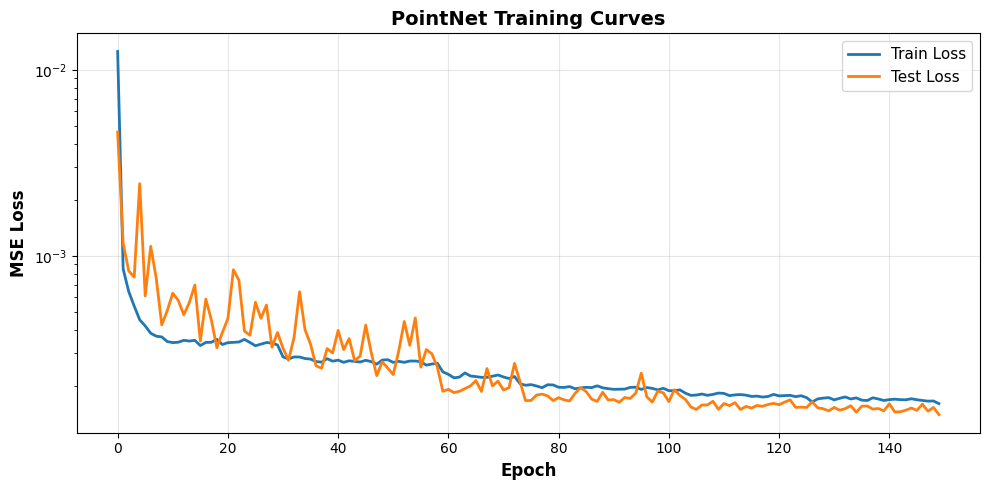

In [9]:
# ==========================================
# PLOT TRAINING CURVES
# ==========================================
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', linewidth=2, color='#1f77b4')
ax.plot(test_losses, label='Test Loss', linewidth=2, color='#ff7f0e')
ax.set_xlabel('Epoch', fontweight='bold', fontsize=12)
ax.set_ylabel('MSE Loss', fontweight='bold', fontsize=12)
ax.set_title('PointNet Training Curves', fontweight='bold', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

In [10]:
# ==========================================
# EVALUATION & METRICS
# ==========================================
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

print("\n" + "=" * 70)
print("EVALUATING MODEL ON TEST SET")
print("=" * 70)

model.eval()

# Collect predictions
test_predictions = []
test_targets_list = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        test_predictions.append(outputs.cpu().numpy())
        test_targets_list.append(targets.cpu().numpy())

test_pred = np.concatenate(test_predictions, axis=0)  # (N_test, 4, 5000)
test_targ = np.concatenate(test_targets_list, axis=0)

print(f"\nTest predictions shape: {test_pred.shape}")
print(f"Test targets shape: {test_targ.shape}")

# Compute R² scores
print("\n" + "=" * 70)
print("R² SCORES (NORMALIZED [0, 1] SPACE)")
print("=" * 70)

r2_scores, rmse_scores, mae_scores = [], [], []

for i, fname in enumerate(field_names):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    
    r2 = r2_score(target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    
    print(f"\n{fname} (Channel {i}):")
    print(f"  R² Score:  {r2:8.6f}")
    print(f"  RMSE:      {rmse:8.6f}")
    print(f"  MAE:       {mae:8.6f}")

print("\n" + "=" * 70)
print("OVERALL SUMMARY")
print("=" * 70)
print(f"Mean R²:   {np.mean(r2_scores):.6f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.6f}")
print(f"Mean MAE:  {np.mean(mae_scores):.6f}")
print("=" * 70)


EVALUATING MODEL ON TEST SET

Test predictions shape: (421, 4, 5000)
Test targets shape: (421, 4, 5000)

R² SCORES (NORMALIZED [0, 1] SPACE)

ux (displacement) (Channel 0):
  R² Score:  0.906214
  RMSE:      0.006198
  MAE:       0.003829

uy (displacement) (Channel 1):
  R² Score:  0.954522
  RMSE:      0.006790
  MAE:       0.004068

uz (displacement) (Channel 2):
  R² Score:  0.979522
  RMSE:      0.009775
  MAE:       0.006038

von Mises stress (Channel 3):
  R² Score:  0.832905
  RMSE:      0.019456
  MAE:       0.012533

OVERALL SUMMARY
Mean R²:   0.918291
Mean RMSE: 0.010555
Mean MAE:  0.006617


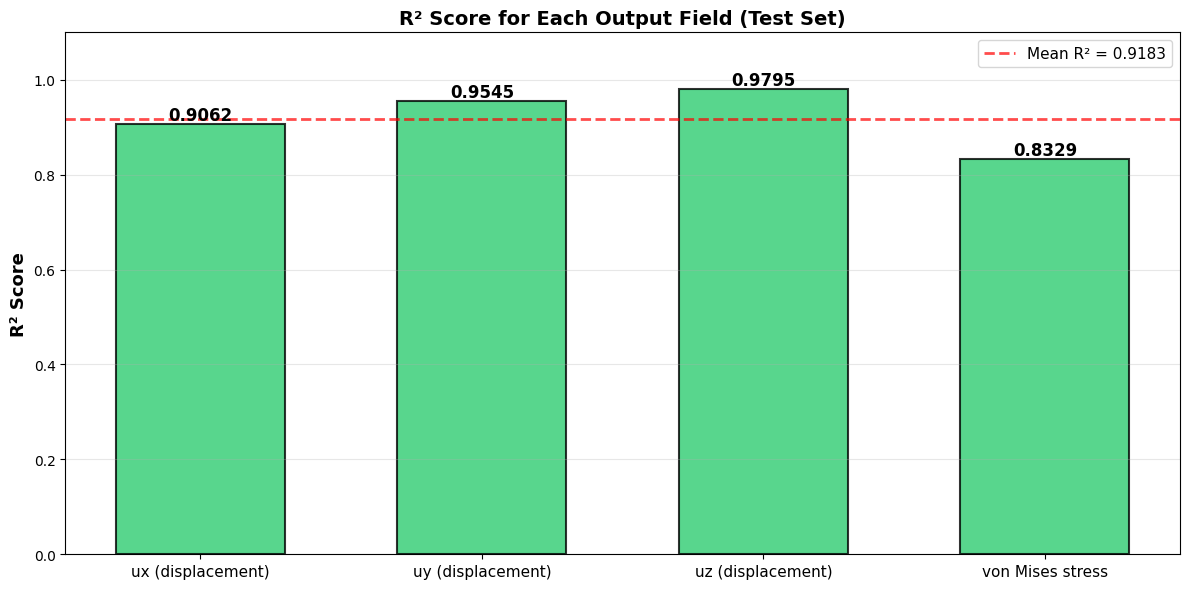

In [11]:
# ==========================================
# VISUALIZATION 1: R² SCORES
# ==========================================
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(field_names))
bars = ax.bar(x_pos, r2_scores, width=0.6, color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)

for bar, r2 in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{r2:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('R² Score', fontweight='bold', fontsize=13)
ax.set_title('R² Score for Each Output Field (Test Set)', fontweight='bold', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(field_names, fontsize=11)
ax.set_ylim([0, 1.1])
ax.axhline(y=np.mean(r2_scores), color='red', linestyle='--', linewidth=2, 
           label=f'Mean R² = {np.mean(r2_scores):.4f}', alpha=0.7)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

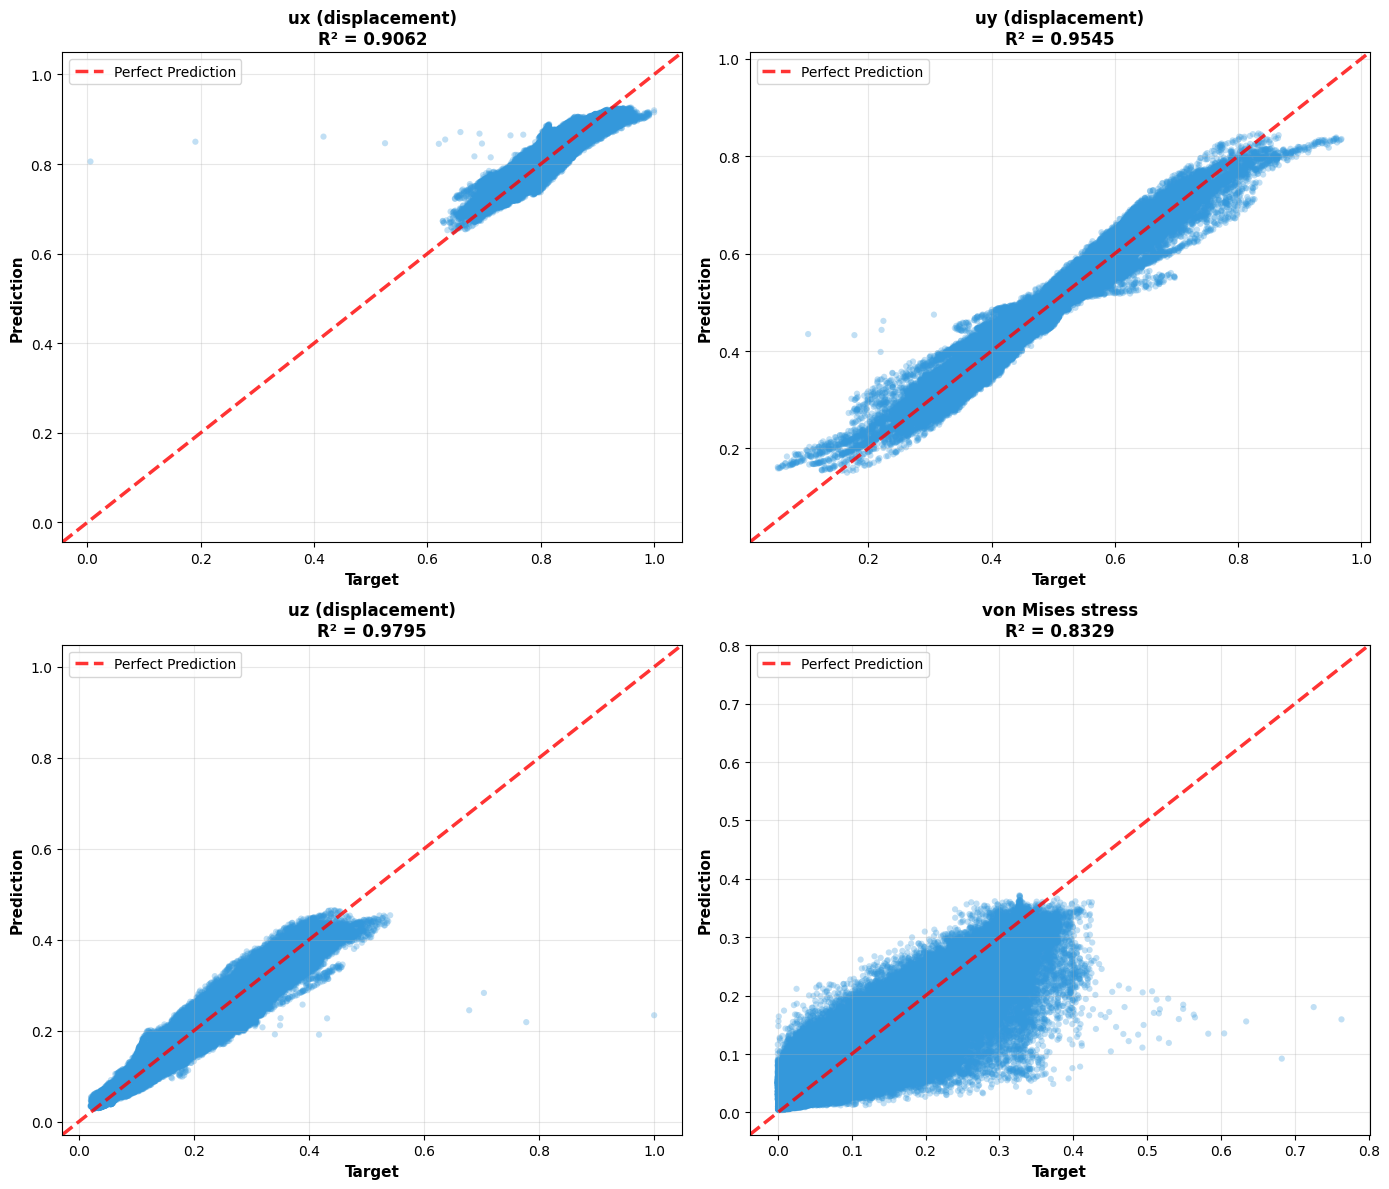

In [12]:
# ==========================================
# VISUALIZATION 2: PREDICTION vs TARGET
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, fname) in enumerate(zip(axes, field_names)):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    
    ax.scatter(target, pred, alpha=0.3, s=20, edgecolors='none', color='#3498db')
    
    min_val = min(target.min(), pred.min())
    max_val = max(target.max(), pred.max())
    margin = (max_val - min_val) * 0.05
    ax.plot([min_val - margin, max_val + margin], [min_val - margin, max_val + margin], 
            'r--', linewidth=2.5, label='Perfect Prediction', alpha=0.8)
    
    ax.set_xlabel('Target', fontweight='bold', fontsize=11)
    ax.set_ylabel('Prediction', fontweight='bold', fontsize=11)
    ax.set_title(f'{fname}\nR² = {r2_scores[i]:.4f}', fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)
    ax.legend(fontsize=10)
    ax.set_xlim([min_val - margin, max_val + margin])
    ax.set_ylim([min_val - margin, max_val + margin])

plt.tight_layout()
plt.show()

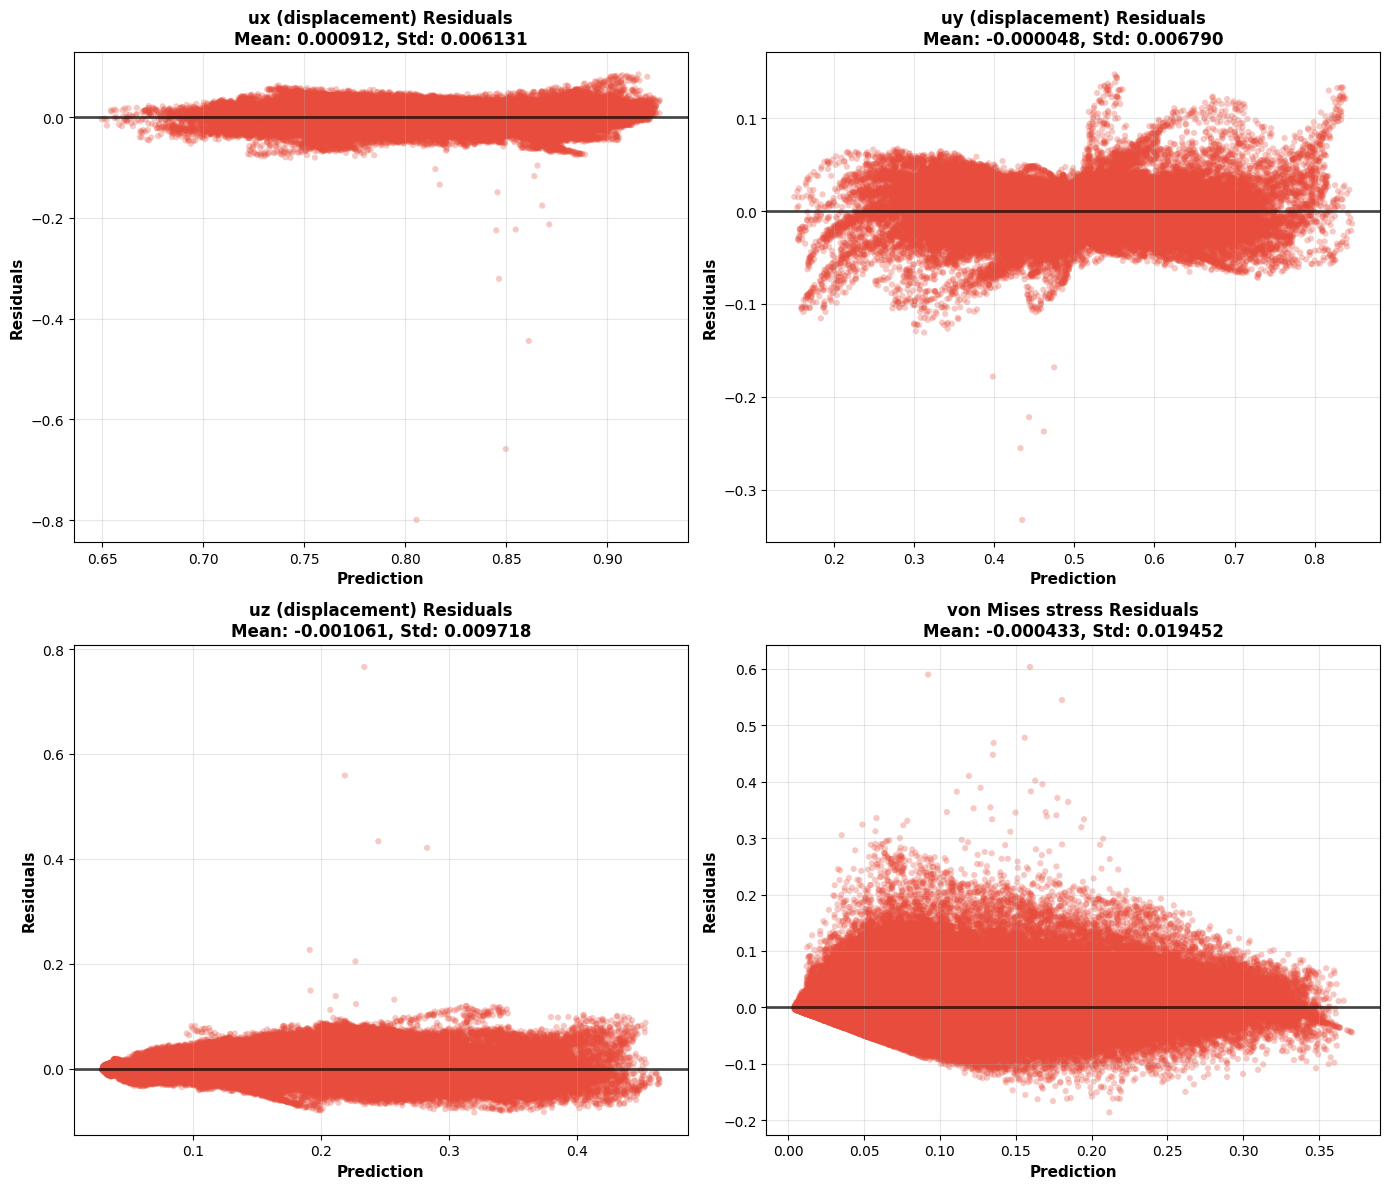

In [13]:
# ==========================================
# VISUALIZATION 3: RESIDUALS
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, fname) in enumerate(zip(axes, field_names)):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    residuals = target - pred
    
    ax.scatter(pred, residuals, alpha=0.3, s=20, edgecolors='none', color='#e74c3c')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2, alpha=0.7)
    
    ax.set_xlabel('Prediction', fontweight='bold', fontsize=11)
    ax.set_ylabel('Residuals', fontweight='bold', fontsize=11)
    ax.set_title(f'{fname} Residuals\nMean: {residuals.mean():.6f}, Std: {residuals.std():.6f}', 
                fontweight='bold', fontsize=12)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

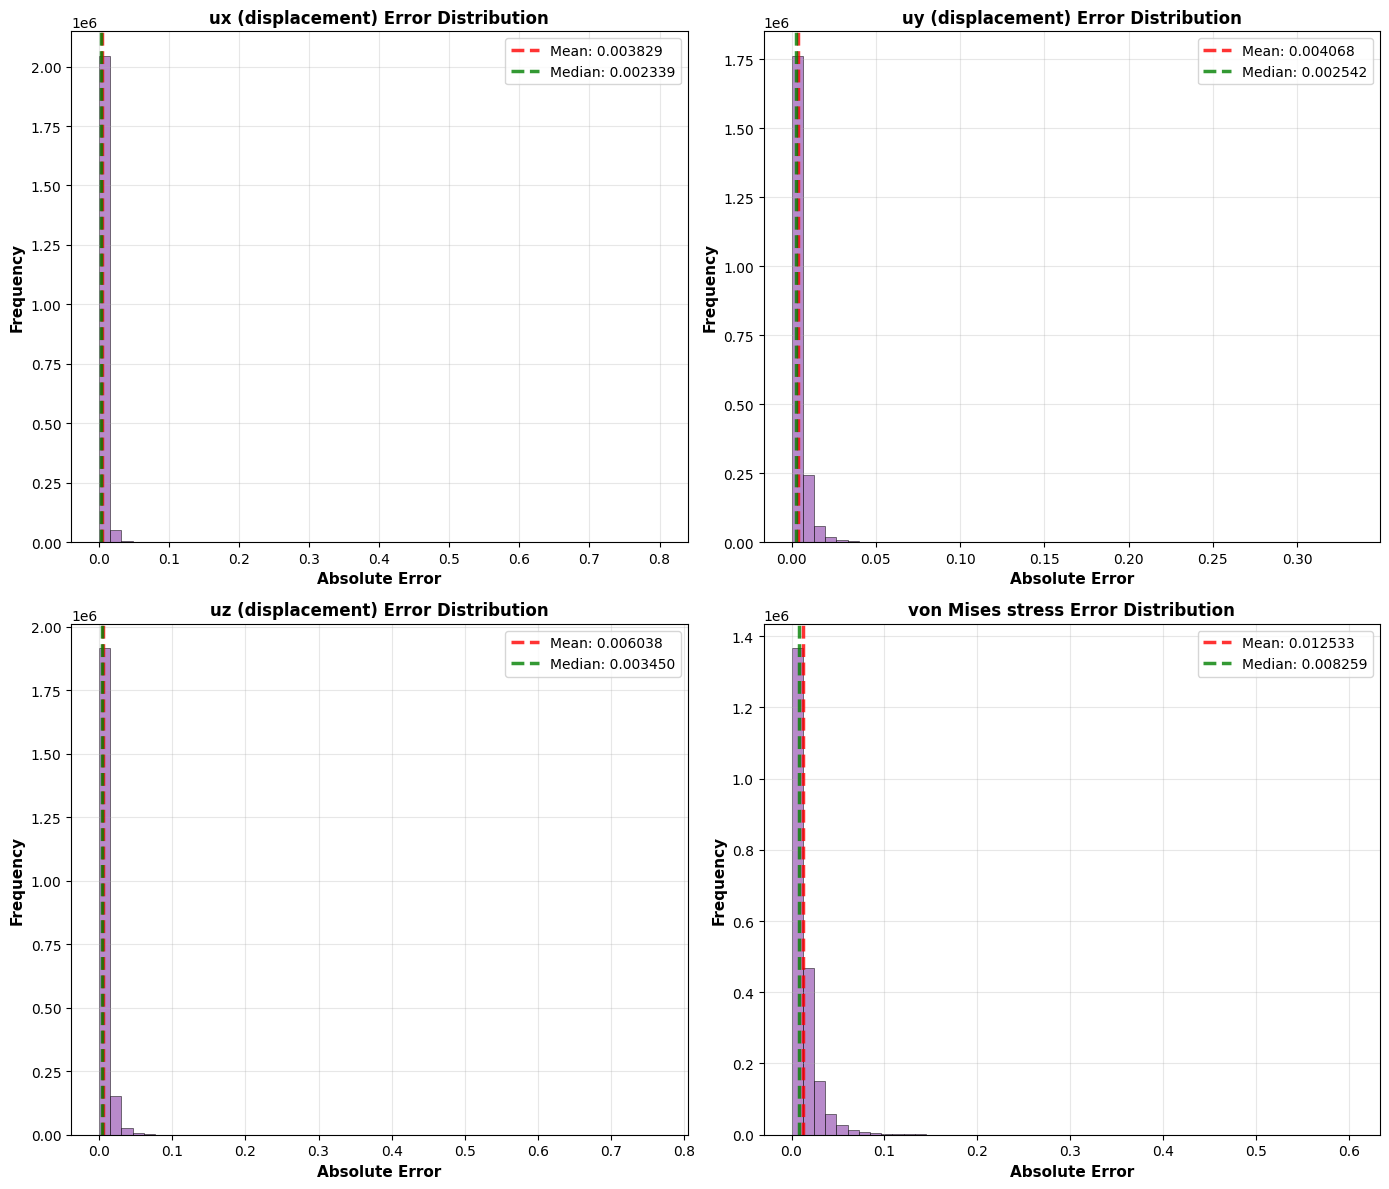

In [14]:
# ==========================================
# VISUALIZATION 4: ERROR DISTRIBUTION
# ==========================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (ax, fname) in enumerate(zip(axes, field_names)):
    pred = test_pred[:, i, :].flatten()
    target = test_targ[:, i, :].flatten()
    errors = np.abs(target - pred)
    
    ax.hist(errors, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=0.5)
    ax.axvline(errors.mean(), color='red', linestyle='--', linewidth=2.5, 
              label=f'Mean: {errors.mean():.6f}', alpha=0.8)
    ax.axvline(np.median(errors), color='green', linestyle='--', linewidth=2.5, 
              label=f'Median: {np.median(errors):.6f}', alpha=0.8)
    
    ax.set_xlabel('Absolute Error', fontweight='bold', fontsize=11)
    ax.set_ylabel('Frequency', fontweight='bold', fontsize=11)
    ax.set_title(f'{fname} Error Distribution', fontweight='bold', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


POINT CLOUD VISUALIZATION: GROUND TRUTH vs PREDICTED
Selected test sample index: 83


C:\Users\dandi\AppData\Local\Temp\ipykernel_35228\1225003048.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.99])


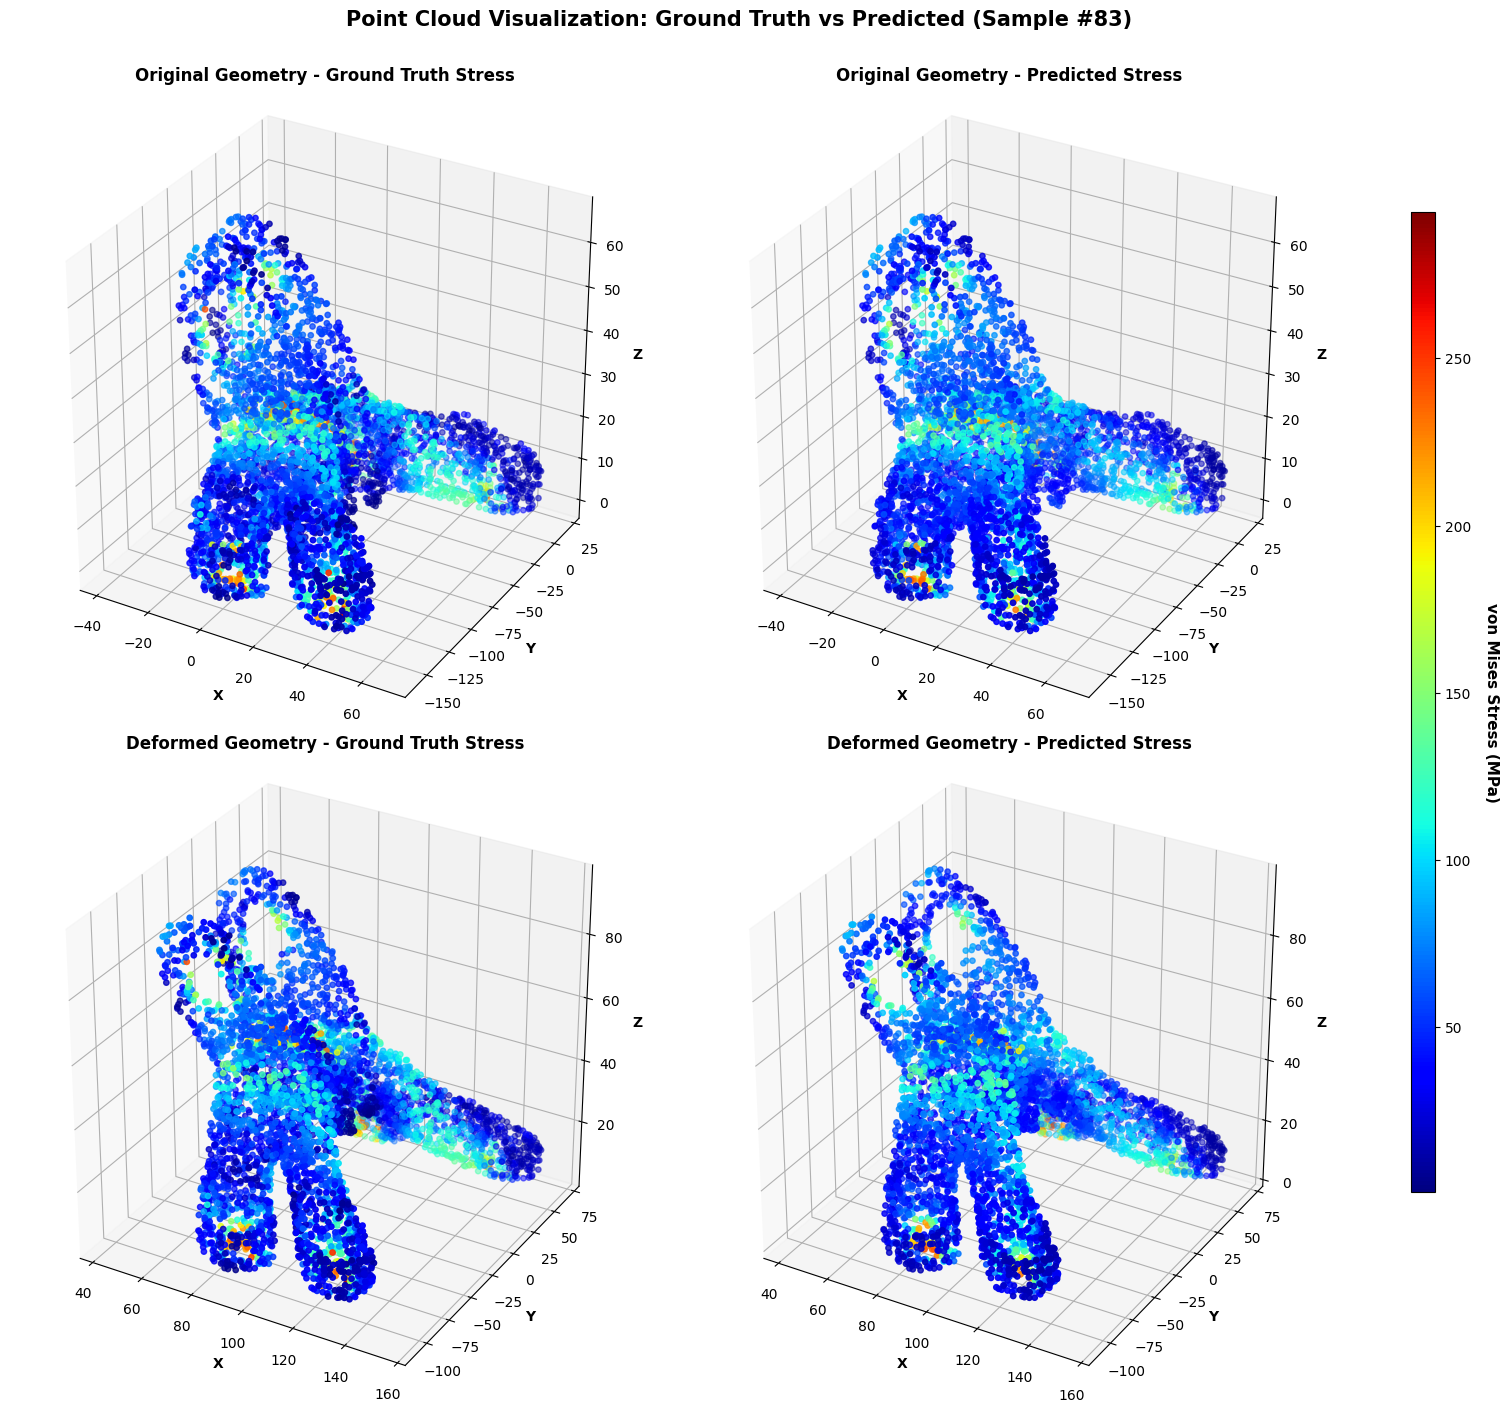


✅ Point cloud visualization complete!

Sample Statistics:
  Original coordinates range: X [-38.70, 68.08]
                              Y [-160.68, 18.00]
                              Z [0.27, 65.33]

  Ground Truth Stress:  Min=0.52, Max=293.65, Mean=62.27 MPa
  Predicted Stress:     Min=8.69, Max=243.64, Mean=63.44 MPa

  Max Displacement (Truth):    110.7256
  Max Displacement (Predicted): 110.9511

  Stress Errors:
    MAE:  12.713806 MPa
    RMSE: 17.241192 MPa
    Max:  133.026428 MPa


In [38]:
# ==========================================
# VISUALIZATION 5: POINT CLOUD COMPARISON
# ==========================================
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

print("\n" + "=" * 70)
print("POINT CLOUD VISUALIZATION: GROUND TRUTH vs PREDICTED")
print("=" * 70)

# Select a random test sample
sample_idx = np.random.randint(0, len(test_input_tensor))
print(f"Selected test sample index: {sample_idx}")

# Get input and outputs (from already-transposed tensors)
sample_input_batch = test_input_tensor[sample_idx:sample_idx+1]  # (1, 3, 5000)
sample_field_truth_batch = test_output_tensor[sample_idx:sample_idx+1]  # (1, 4, 5000)

# Get coordinates from original data (not transposed)
coords_original = test_input_xyz[sample_idx]  # (5000, 3)
sample_field_truth = test_field_norm[sample_idx]  # (5000, 4)

# Generate predictions using PointNet
model.eval()
with torch.no_grad():
    sample_input_batch = sample_input_batch.to(device)
    sample_field_pred_batch = model(sample_input_batch)  # (1, 4, 5000)
    sample_field_pred = sample_field_pred_batch.cpu().numpy()[0].T  # (5000, 4)

# Extract field components
displacements_truth = sample_field_truth[:, :3]
stress_truth = sample_field_truth[:, 3]

displacements_pred = sample_field_pred[:, :3]
stress_pred = sample_field_pred[:, 3]

# Denormalize stress to original scale
stress_truth_actual = stress_truth * (field_max[3] - field_min[3]) + field_min[3]
stress_pred_actual = stress_pred * (field_max[3] - field_min[3]) + field_min[3]

# Scale displacements for visualization
displacement_scale = 100
displacements_truth_scaled = displacements_truth * displacement_scale
displacements_pred_scaled = displacements_pred * displacement_scale

# Create deformed coordinates
coords_truth_deformed = coords_original + displacements_truth_scaled
coords_pred_deformed = coords_original + displacements_pred_scaled

# Visualization: 2x2 grid (Original & Deformed, Ground Truth & Predicted)
fig = plt.figure(figsize=(16, 14))

# Color map settings
cmap = plt.colormaps['jet']
cmax = np.max([stress_truth_actual.max(), stress_pred_actual.max()])
cmin = np.min([stress_truth_actual.min(), stress_pred_actual.min()])
norm = Normalize(vmin=cmin, vmax=cmax)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

# ==========================================
# Row 1: ORIGINAL GEOMETRY
# ==========================================
# Original - Ground Truth
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.scatter(
    coords_original[:, 0], coords_original[:, 1], coords_original[:, 2],
    c=stress_truth_actual, cmap='jet', s=15, vmin=cmin, vmax=cmax
)
ax1.set_xlabel('X', fontweight='bold')
ax1.set_ylabel('Y', fontweight='bold')
ax1.set_zlabel('Z', fontweight='bold')
ax1.set_title('Original Geometry - Ground Truth Stress', fontweight='bold', fontsize=12)
ax1.set_box_aspect([1, 1, 1])

# Original - Predicted
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax2.scatter(
    coords_original[:, 0], coords_original[:, 1], coords_original[:, 2],
    c=stress_pred_actual, cmap='jet', s=15, vmin=cmin, vmax=cmax
)
ax2.set_xlabel('X', fontweight='bold')
ax2.set_ylabel('Y', fontweight='bold')
ax2.set_zlabel('Z', fontweight='bold')
ax2.set_title('Original Geometry - Predicted Stress', fontweight='bold', fontsize=12)
ax2.set_box_aspect([1, 1, 1])

# ==========================================
# Row 2: DEFORMED GEOMETRY
# ==========================================
# Deformed - Ground Truth
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
ax3.scatter(
    coords_truth_deformed[:, 0], coords_truth_deformed[:, 1], coords_truth_deformed[:, 2],
    c=stress_truth_actual, cmap='jet', s=15, vmin=cmin, vmax=cmax
)
ax3.set_xlabel('X', fontweight='bold')
ax3.set_ylabel('Y', fontweight='bold')
ax3.set_zlabel('Z', fontweight='bold')
ax3.set_title('Deformed Geometry - Ground Truth Stress', fontweight='bold', fontsize=12)
ax3.set_box_aspect([1, 1, 1])

# Deformed - Predicted
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
ax4.scatter(
    coords_pred_deformed[:, 0], coords_pred_deformed[:, 1], coords_pred_deformed[:, 2],
    c=stress_pred_actual, cmap='jet', s=15, vmin=cmin, vmax=cmax
)
ax4.set_xlabel('X', fontweight='bold')
ax4.set_ylabel('Y', fontweight='bold')
ax4.set_zlabel('Z', fontweight='bold')
ax4.set_title('Deformed Geometry - Predicted Stress', fontweight='bold', fontsize=12)
ax4.set_box_aspect([1, 1, 1])

# Add shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar = fig.colorbar(scalar_map, cax=cbar_ax)
cbar.set_label('von Mises Stress (MPa)', rotation=270, labelpad=20, fontweight='bold', fontsize=11)

# Overall title
fig.suptitle(f'Point Cloud Visualization: Ground Truth vs Predicted (Sample #{sample_idx})', 
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 0.91, 0.99])
plt.show()

print(f"\n✅ Point cloud visualization complete!")
print(f"\nSample Statistics:")
print(f"  Original coordinates range: X [{coords_original[:, 0].min():.2f}, {coords_original[:, 0].max():.2f}]")
print(f"                              Y [{coords_original[:, 1].min():.2f}, {coords_original[:, 1].max():.2f}]")
print(f"                              Z [{coords_original[:, 2].min():.2f}, {coords_original[:, 2].max():.2f}]")
print(f"\n  Ground Truth Stress:  Min={stress_truth_actual.min():.2f}, Max={stress_truth_actual.max():.2f}, Mean={stress_truth_actual.mean():.2f} MPa")
print(f"  Predicted Stress:     Min={stress_pred_actual.min():.2f}, Max={stress_pred_actual.max():.2f}, Mean={stress_pred_actual.mean():.2f} MPa")
print(f"\n  Max Displacement (Truth):    {np.linalg.norm(displacements_truth_scaled, axis=1).max():.4f}")
print(f"  Max Displacement (Predicted): {np.linalg.norm(displacements_pred_scaled, axis=1).max():.4f}")

# Calculate errors for this sample
stress_mae = np.mean(np.abs(stress_truth_actual - stress_pred_actual))
stress_rmse = np.sqrt(np.mean((stress_truth_actual - stress_pred_actual) ** 2))
stress_max_error = np.max(np.abs(stress_truth_actual - stress_pred_actual))

print(f"\n  Stress Errors:")
print(f"    MAE:  {stress_mae:.6f} MPa")
print(f"    RMSE: {stress_rmse:.6f} MPa")
print(f"    Max:  {stress_max_error:.6f} MPa")